In [143]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
import random

In [3]:
path = '/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/TwoClassModelsV2'
Main_path = '/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow'

In [3]:
train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)

trainY = train_Y.to_numpy()
trainX = train_X.to_numpy()
trainX = np.expand_dims(trainX,axis=2)

minimum = np.amin(trainX)
maximum = np.amax(trainX)

In [4]:
accuracy_df = pd.read_csv(path+"/Accuracy.csv")
accuracy_df

,Class Tuples,A_Count,B_Count,Other_Count,Correct?
0,"0,3",110,130,0,240
1,"0,4",97,143,0,240
2,"2,4",0,240,0,240
3,"3,0",135,105,0,240
4,"3,4",119,121,0,240
...,...,...,...,...,...
177,"2,9",0,0,240,-240
178,"2,10",0,0,240,-240
179,"7,2",0,0,240,-240
180,"10,1",0,0,240,-240


In [139]:
classification_model = tf.keras.models.load_model('TrainedModel/trainedModel.h5')

## Define bivariate normal distribution pdf

In [6]:
def biVariate_Prob(coVariance,mean,x):
    
    LHS = np.power(np.linalg.det(2*np.pi*coVariance),-0.5)
    
    RHS = np.exp(-0.5*np.dot(((x-mean).T),(np.dot(np.linalg.inv(coVariance),(x-mean)))))
    
    return LHS*RHS
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.3999999994412065
16.600000000093132
[[6.4446806e-04 5.4267734e-05 1.6971133e-04 1.8988805e-03 8.7422011e-03
  3.0311644e-02 3.1091113e-05 2.9547105e-06 1.8953310e-01 1.5795274e-01
  1.0498756e-03 5.7972181e-01 2.6792517e-02 3.0947318e-03]]


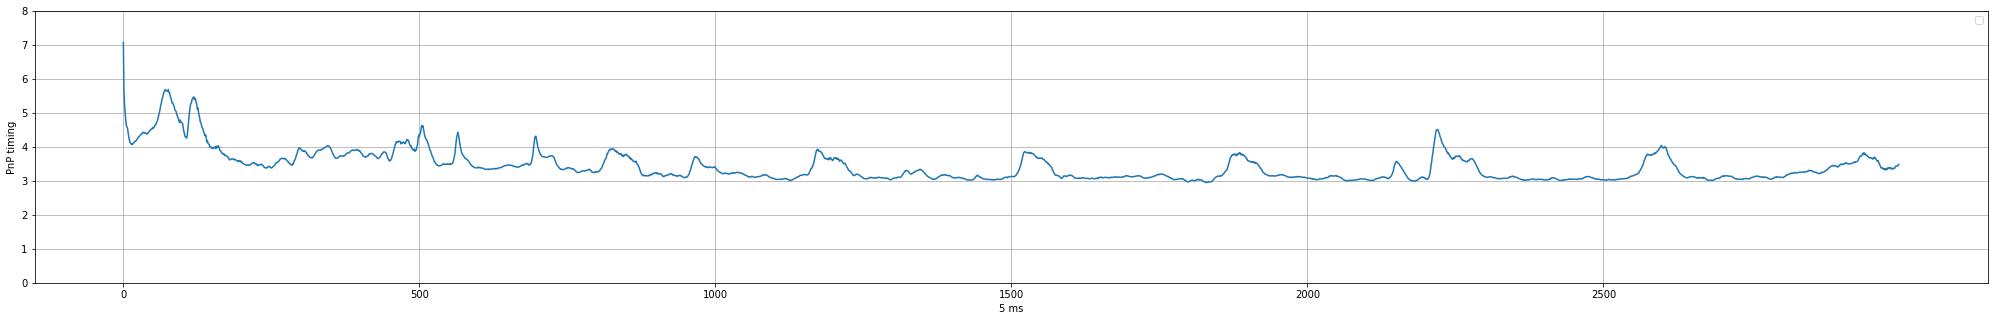

In [23]:
#%matplotlib widget
#%matplotlib inline

for index, row in accuracy_df.iterrows():
    
    
    #Checking if the specific class Tuple has enough points for both A and B 
    if((row['Correct?'] > 120) and (row['A_Count'] > 50) and (row['B_Count'] > 50)):
        
        #Extracting classA classB tuple from Accuracy.csv
        my_list = row['Class Tuples'].split(",")
        classA = int(my_list[0])
        classB = int(my_list[1])
        
        #Uncomment below if you need to force class A and class B to be certain values. Dont forget to add break at the end of for loop
        classA = 3
        classB = 11
        
        
        
        #Loading the corresponding decoder of class A, classB combination 
        decoder = tf.keras.models.load_model(path+"/"+str(classA)+"/"+str(classB)+"/modeldecoder.h5")

        points = pd.read_csv(path+"/"+str(classA)+"/"+str(classB)+"/points.csv")
        points = points.drop(['Unnamed: 0'], axis=1)
        
        X_A = points["X_A"].to_numpy()
        Y_A = points["Y_A"].to_numpy()

        X_B = points["X_B"].to_numpy()
        Y_B = points["Y_B"].to_numpy()
        
        X_A = X_A[~np.isnan(X_A)]
        Y_A = Y_A[~np.isnan(Y_A)]
        
        X_B = X_B[~np.isnan(X_B)]
        Y_B = Y_B[~np.isnan(Y_B)]
        
        #Might be implemented incorrectly, check while debugging! Update: Honestly, this is a disgusting way to do it and I'm ashamed but it works so I'm not touching it!
        APoints = np.vstack((X_A, Y_A))
        covA = np.cov(APoints)
        
        BPoints = np.vstack((X_B, Y_B))
        covB = np.cov(BPoints)
        
        
        
        
        #Parameters to set ---- A
        mu_x_A = np.mean(X_A)
        variance_x_A = covA[0][0]
        mu_y_A = np.mean(Y_A)
        variance_y_A = covA[1][1]
        mu_A = np.array([mu_x_A,mu_y_A])
        
        
        #Parameters to set ---- B
        mu_x_B = np.mean(X_B)
        variance_x_B = covB[0][0]
        mu_y_B = np.mean(Y_B)
        variance_y_B = covB[1][1]
        mu_B = np.array([mu_x_B,mu_y_B])
        
        
        #Printing covariances and means for debugging purposes
        #print("Class A")
        #print("Covariance: "+ str(covA))
        #print("Mean: "+ str(mu_A))
        #print("-----------")
        #print("Class B")
        #print("Covariance: "+ str(covB))
        #print("Mean: "+ str(mu_B))
        
        
        maxY = np.amax([np.amax(Y_A),np.amax(Y_B)])
        maxX = np.amax([np.amax(X_A),np.amax(X_B)])
        
        minY = np.amin([np.amin(Y_A),np.amin(Y_B)])
        minX = np.amin([np.amin(X_A),np.amin(X_B)])
        
        #decreaseRate= how much should the box be smaller than the normal enclosing box that normally would be. This is done because the box is, well... literally a box. The edges are not even between two clusters-
        #and so the edges of the box correspond to points outside of the two clusters, and therefore E[clusterA]-E[clusterB] still gives super small numbers but end up being wrong.
        #POSSIBLE OPTIMIZATION: make the linspace a circle instead of a box, should technically help a lot!
        decreaseRate = 0.9
        x = np.linspace(maxX-decreaseRate, minX+decreaseRate, num=50)
        y = np.linspace(maxY-decreaseRate, minY+decreaseRate, num=50)
        
        
        
        x_array = []
        y_array = []
        z_array = []
        
        
        
        bestPoints_for_normal = []
        #print(bestPoints_for_normal.shape)
        #print(np.expand_dims(bestPoints_for_normal,axis=1).shape)
        summa = 0
        for x_i in x:
            
            best_Point_x = []
            best_Point_y = []
            best_Point_difference = []
            
            for y_i in y:
                
                #calculating differences with respect to biVariate expectation, and then appending it to z_array
                difference = abs(biVariate_Prob(covA,mu_A,[x_i,y_i])-biVariate_Prob(covB,mu_B,[x_i,y_i]))
                
                #Append to global array
                x_array.append(x_i)
                y_array.append(y_i)
                z_array.append(difference)
                
                #Append to array that exists only for specific y
                best_Point_x.append(x_i)
                best_Point_y.append(y_i)
                best_Point_difference.append(difference)
                
            YPoints = np.append(np.array([best_Point_x]).T,np.array([best_Point_y]).T,axis=1)
            
            smallestPoint = YPoints[np.argmin(best_Point_difference)]
            #print(smallestPoint)
            #break
                                           
            
            #print(YPoints[np.argmin(best_Point_difference)].shape)
            
            #break
            #best_PointFor_Y = np.append(best_PointFor_Y,np.array([best_Point_difference]).T,axis=1)
            
            bestPoints_for_normal.append(smallestPoint)
            #bestPoints_for_normal = np.append(bestPoints_for_normal,smallestPoint,axis=1)
            
        bestPoints_for_normal = np.array(bestPoints_for_normal)
        
        
            
         
        #Appending x_array, y_array, and z_array together to create a matrix
        Points = np.append(np.array([x_array]).T,np.array([y_array]).T,axis=1)
        Points = np.append(Points,np.array([z_array]).T,axis=1)
        
        
        
        #Taking first two columns of Points (x,y), and reconstructing and classifying and taking the confidences of classA and class B and putting it back to x,y array as the 3rd column. For some reason all this can be done in 4 lines
        #Magic of Python and Numpy
        pointsForClassification = Points[:,0:2]
        reconstructions = decoder.predict(Points[:,0:2])
        confidences = classification_model.predict(reconstructions)
        differencesWRTClassification = abs(confidences[:, [classA]]-confidences[:, [classB]])
        
        
        #THESE ARE THE TWO POINT ARRAYS WHERE THE 3RD COLUMN IS EITHER DIFFERENCE WRT NORMAL OR DIFFERENCE WRT CLASSIFICATION MODEL
        PointsNormal = Points
        PointsClassification = np.append(Points[:,0:2],differencesWRTClassification,axis=1)
        
        #SORTING THE ARRAYS WRT 3RD COLUMN(DIFFERENCES)
        sortedPointsClassification = PointsClassification[PointsClassification[:,2].argsort()]
        sortedPointsNormal = PointsNormal[PointsNormal[:,2].argsort()]
        
        
        
        amountToCut = 50
        
        #Sampling multivariate random from given covariance and mean for class A
        randomSamples = []
        for i in range(amountToCut):
            randomSample = np.random.multivariate_normal(mu_A,covA)
            randomSamples.append(randomSample)
            
        randomSamples = np.array(randomSamples).T
        
        reconstructions_From_Middle = decoder.predict(bestPoints_for_normal)
        reconstructions_From_Random = decoder.predict(randomSamples.T)
        
        NoiseA = reconstructions_From_Middle-reconstructions_From_Random
        
        #Sampling multivariate random from given covariance and mean for class B
        randomSamples = []
        for i in range(amountToCut):
            randomSample = np.random.multivariate_normal(mu_B,covB)
            randomSamples.append(randomSample)
            
        randomSamples = np.array(randomSamples).T
        
        reconstructions_From_Middle = decoder.predict(bestPoints_for_normal)
        reconstructions_From_Random = decoder.predict(randomSamples.T)
        
        NoiseB = reconstructions_From_Middle-reconstructions_From_Random
        
        if(True):
            
            isExist = os.path.exists(Main_path+"/Noise/"+str(classA))
            if not isExist:
              # Create a new directory because it does not exist 
              os.makedirs(Main_path+"/Noise/"+str(classA))
                
            isExist = os.path.exists(Main_path+"/Noise/"+str(classB))
            if not isExist:
              # Create a new directory because it does not exist 
              os.makedirs(Main_path+"/Noise/"+str(classB))
            
            #print(np.squeeze(NoiseA,axis=2).shape)
            
            np.savetxt(Main_path+"/Noise/"+str(classA)+"/"+str(classB)+".csv", np.squeeze(NoiseA * (maximum-minimum)+minimum,axis=2), delimiter=",")
            np.savetxt(Main_path+"/Noise/"+str(classB)+"/"+str(classA)+".csv", np.squeeze(NoiseB * (maximum-minimum)+minimum,axis=2), delimiter=",")
            
            
            
        
        
        
        #MOST BOTTOM IF STATEMENTS ARE TESTS
        #------------------------------------------------------
        if(False):
            train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
            train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)
            
            trainY = train_Y.to_numpy()
            trainX = train_X.to_numpy()
            trainX = np.expand_dims(trainX,axis=2)
            
            minimum = np.amin(trainX)
            maximum = np.amax(trainX)
            
            amt = 20
            x = np.linspace(mu_x_A, mu_x_B, num=amt)
            y = np.linspace(mu_y_A, mu_y_B, num=amt)
            
            together = np.append([x],[y],axis=0).T
            reconstructed = decoder.predict(together)
            
            reconstructed = reconstructed * (maximum-minimum)+minimum
            
            for i in range(amt):
                fig = plt.figure(figsize=(35,5))


                plt.plot(reconstructed[i].T[0])

                plt.legend()
                plt.yticks(np.arange(0, 9, 1))
                plt.xticks(np.arange(0, 3000, 500))
                plt.grid()
                
                plt.xlabel("5 ms")
                plt.ylabel("PnP timing")
                fig.savefig("Graphs/"+str(i)+".png",dpi=200)
                
                
            #print(reconstructed[0].T[0])
            
            
        #-------------------------------------------------------
        if(True):
            train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
            train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)
            
            amt = 20
            x = np.linspace(mu_x_A, mu_x_B, num=amt)
            y = np.linspace(mu_y_A, mu_y_B, num=amt)
            
            together = np.append([x],[y],axis=0).T
            
            #print(together[7].tolist())
            #print([[mu_x_A,mu_y_A]])

            reconstruction_test = decoder.predict([together[11].tolist()])


            specificReconstruction = reconstructions_From_Middle[25]

            trainY = train_Y.to_numpy()
            trainX = train_X.to_numpy()
            trainX = np.expand_dims(trainX,axis=2)

            minimum = np.amin(trainX)
            maximum = np.amax(trainX)

            print(minimum)
            print(maximum)

            #print(randomSamples.T[25])

            fig = plt.figure(figsize=(35,5))
            
            #print(reconstruction_test[0].T[0])
            

            #print(specificReconstruction.T)

            #plt.plot(NoiseA[25].T[0]*(maximum-minimum)+minimum)
            #plt.plot(specificReconstruction.T[0]*(maximum-minimum)+minimum)
            plt.plot(reconstruction_test[0].T[0]*(maximum-minimum)+minimum)
            
            #reconst = np.expand_dims(reconstruction_test[0].T[0],axis=1)
            print(classification_model.predict(reconstruction_test))

            plt.legend()
            plt.yticks(np.arange(0, 9, 1))
            plt.xticks(np.arange(0, 3000, 500))
            plt.grid()
            #plt.axhline(linewidth=1, color='r')
            plt.xlabel("5 ms")
            plt.ylabel("PnP timing")
            fig.savefig("Graphs/"+str(i)+".png",dpi=200)
            #-------------------------------------------------------
        break
        
        #print(NoiseA)
        #print("---------")
        #print(NoiseB)
        
        
        #THIS IS ALL AFTER NOISE IS CALCULATED FOR CLASS A AND B
        if(False):
            train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
            train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)

            trainY = train_Y.to_numpy()
            trainX = train_X.to_numpy()
            trainX = np.expand_dims(trainX,axis=2)

            minimum = np.amin(trainX)
            maximum = np.amax(trainX)

            trainX_normalized = (trainX-minimum)/(maximum-minimum)

            trainX_tensor =  tf.convert_to_tensor(trainX_normalized)
            output = tf.nn.max_pool1d(trainX_tensor, 2, 2, padding='VALID')

            trainA = pooled_dataset[classA::14]
            trainB = pooled_dataset[classB::14]

            trainA_Out = trainY[classA::14]
            trainB_Out = trainY[classB::14]

            finalX = np.append(trainA,trainB,axis=0)
            finalY = np.append(trainA_Out,trainB_Out)
            
        
        if(False):
            i = 0
            for rec in reconstructions_From_Middle:
                
                fig = plt.figure(figsize=(35,5))
                #plt.plot(results)

                #sampleToPredict = 15

                #plt.plot(reconstructed_x[sampleToPredict],label='Reconstruction')
                #plt.plot(trainXCUT[sampleToPredict],label='Sample')
                #plt.plot(data3[0],label=3)
                #plt.plot(data4[0],label=4)
                plt.plot(rec.T[0])

                plt.legend()
                plt.yticks(np.arange(0, 1, 0.1))
                plt.xticks(np.arange(0, 3000, 500))
                plt.grid()
                #plt.axhline(linewidth=1, color='r')
                plt.xlabel("5 ms")
                plt.ylabel("PnP timing")
                #figure(figsize=(8, 6), dpi=80)
                fig.savefig("Graphs/"+str(i)+".png",dpi=200)
                i = i +1
                
            
            
        
        
        
        
        #PLOTTING
        if(False):
            fig = plt.figure(figsize=(13,10))

            plt.scatter(X_A,Y_A,color='r',label="Class "+str(classA))
            plt.scatter(X_B,Y_B,color='b',label="Class "+str(classB))

            #plt.scatter(sortedPointsNormal[0:amountToCut,0:1].T[0],sortedPointsNormal[0:amountToCut,1:2].T[0],color='y',label="Middle According to Normal")
            plt.scatter(sortedPointsClassification[0:amountToCut,0:1].T[0],sortedPointsClassification[0:amountToCut,1:2].T[0],color='g',label="Middle According to Classification")
            plt.scatter(bestPoints_for_normal[:,0],bestPoints_for_normal[:,1],color='y',label="Middle According to Berk")
            plt.scatter(randomSamples[0],randomSamples[1],color='k')
            
            plt.axhline(y=0, color='k', linestyle='-')
            plt.axvline(x=0, color='k', linestyle='-')
            plt.legend()

        
        print(row)
        
        


## Test Noise Array

In [4]:
train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)

In [6]:
trainY = train_Y.to_numpy()
trainX = train_X.to_numpy()
trainX = np.expand_dims(trainX,axis=2)

In [8]:
trainX.shape

(1680, 6000, 1)

In [9]:
trainX_tensor =  tf.convert_to_tensor(trainX)
finalX = tf.nn.max_pool1d(trainX, 2, 2, padding='VALID')

2022-04-29 11:47:58.271843: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 11:47:58.832983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22306 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-04-29 11:48:00.191643: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [58]:
finalX = finalX.numpy()

In [59]:
finalX.shape

(1680, 3000, 1)

In [157]:
numOfClasses = 14
NoiseToAdd = np.zeros(finalX.shape)
NoiseToAdd = np.squeeze(NoiseToAdd)
eachClassSize = int(len(trainY)/numOfClasses)

for i in range(numOfClasses):
    print("Class: "+str(i))
    
    isExist = os.path.exists(Main_path+"/Noise/"+str(i))
    if isExist:
    
        target_files = os.listdir(Main_path+"/Noise/"+str(i))

        noiseArrayForSingleClass = []

        for file in target_files:
            single_target = pd.read_csv(Main_path+"/Noise/"+str(i)+"/"+file, header=None).to_numpy()
            noiseArrayForSingleClass.append(single_target)

        noiseForSingleClass = np.reshape(np.array(noiseArrayForSingleClass), (len(target_files)*50,3000))
        
        j = i
        while(j<len(trainY)):
            
            #print(random.randint(0,len(noiseForSingleClass)-1))
            NoiseToAdd[j] = noiseForSingleClass[random.randint(0,len(noiseForSingleClass)-1)]
            j = j +numOfClasses
    
NoiseToAdd = np.expand_dims(NoiseToAdd,axis=2)
print(NoiseToAdd.shape)

Class: 0
Class: 1
Class: 2
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7
Class: 8
Class: 9
Class: 10
Class: 11
Class: 12
Class: 13
(1680, 3000, 1)


In [173]:
NoiseToAdd[NoiseToAdd < 0] = 0
finalXwNoise = finalX + 10*NoiseToAdd

In [169]:

minimum = np.amin(trainX)
maximum = np.amax(trainX)

trainX_normalized = (finalXwNoise-minimum)/(maximum-minimum)



In [170]:
trainX_normalized.shape

(1680, 3000, 1)

In [171]:
classification_model.evaluate(trainX_normalized,trainY)

53/53 [==============================] - 0s 3ms/step - loss: 27.3436 - accuracy: 0.3143


[27.34356689453125, 0.3142857253551483]

### Train New Model w Noise

In [144]:
numberOfWebsites = 14
def my_model_sddec():

    input_1 = keras.Input(shape = (3000,1))

    conv1d_1 = layers.Conv1D(256,16,strides=3,padding='valid',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(input_1)#possibly update kernel_initializer
    max_pooling1d_1 = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(conv1d_1)

    conv1d_2 = layers.Conv1D(128,8,strides=3,padding='valid',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(max_pooling1d_1)#possibly update kernel_initializer
    max_pooling1d_2 = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(conv1d_2)

    conv1d_3 = layers.Conv1D(32,8,strides=3,padding='same',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(max_pooling1d_2)#possibly update kernel_initializer
    max_pooling1d_2 = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(conv1d_3)

    # conv1d_1 = layers.Conv1D(256,16,strides=3,padding='valid',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(input_1)#possibly update kernel_initializer
    
    # max_pooling1d_1 = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(conv1d_1)
    
    # conv1d_2 = layers.Conv1D(32,8,strides=3,padding='same',activation='relu',use_bias=True,kernel_initializer='VarianceScaling',bias_initializer = 'Zeros')(max_pooling1d_1)#possibly update kernel_initializer

    # max_pooling1d_2 = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(conv1d_2)

    #lstm_1 = layers.LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,kernel_initializer='VarianceScaling',recurrent_initializer = 'orthogonal',bias_initializer='Zeros', return_sequences = True)(max_pooling1d_2) #Variance Scaling

    flatten_1 = layers.Flatten()(max_pooling1d_2)
    
    #x = layers.Dense(200,activation = 'softmax')(flatten_1)

    #dropout_1 = layers.Dropout(0.3)(flatten_1)

    #dense_1 = layers.Dense(300,activation = 'relu')(dropout_1)

    #dropout_2 = layers.Dropout(0.5)(x)

    dense_2= layers.Dense(numberOfWebsites, kernel_regularizer = 'l2',activation = 'softmax', kernel_initializer = 'VarianceScaling', bias_initializer = 'zeros')(flatten_1)

    model = keras.Model(inputs = input_1, outputs = dense_2)
    return model

In [145]:

model = my_model_sddec()

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 995, 256)          4352      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 128)           262272    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 32)             32800 

In [172]:
model.compile(
	loss=keras.losses.SparseCategoricalCrossentropy(),
	optimizer=keras.optimizers.Adam(),
	metrics=["accuracy"]
)

history = model.fit(trainX_normalized, trainY,validation_split = 0.3, batch_size=32, epochs=25, verbose=1)

Epoch 1/25
37/37 [==============================] - 1s 11ms/step - loss: 0.2489 - accuracy: 0.9413 - val_loss: 0.6281 - val_accuracy: 0.8790
Epoch 2/25
37/37 [==============================] - 0s 7ms/step - loss: 0.1959 - accuracy: 0.9592 - val_loss: 0.6287 - val_accuracy: 0.8849
Epoch 3/25
37/37 [==============================] - 0s 7ms/step - loss: 0.1644 - accuracy: 0.9592 - val_loss: 0.5366 - val_accuracy: 0.8988
Epoch 4/25
37/37 [==============================] - 0s 6ms/step - loss: 0.1185 - accuracy: 0.9804 - val_loss: 0.5977 - val_accuracy: 0.8849
Epoch 5/25
37/37 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9643 - val_loss: 0.6310 - val_accuracy: 0.8730
Epoch 6/25
37/37 [==============================] - 0s 6ms/step - loss: 0.1492 - accuracy: 0.9702 - val_loss: 0.5301 - val_accuracy: 0.9048
Epoch 7/25
37/37 [==============================] - 0s 6ms/step - loss: 0.1101 - accuracy: 0.9821 - val_loss: 0.4988 - val_accuracy: 0.9028
Epoch 8/25
37/37 [=

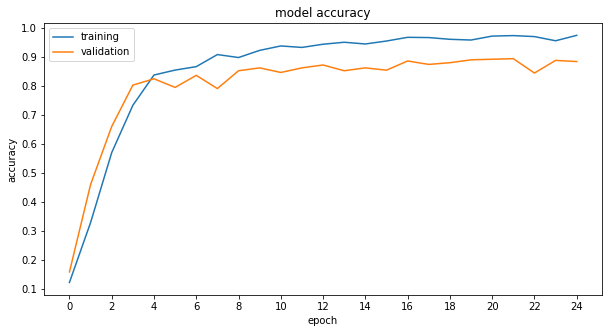

In [152]:
fig = plt.figure(figsize=(10,5))


#plotting

plt.locator_params(axis="x", nbins=20)
plt.locator_params(axis="y", nbins=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
fig.savefig('plot.png',dpi=200)

In [154]:
np.var(trainX_normalized,axis=0)

array([[0.01256666],
       [0.01082808],
       [0.01031671],
       ...,
       [0.00572205],
       [0.00565246],
       [0.00557239]])